In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [2]:
import os
import pickle
from pathlib import Path
import re
from functools import partial
import json

import numpy as np
from scipy.special import logit, expit
from scipy import stats
from scipy.optimize import minimize_scalar
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, GammaRegressor
from sklearn.pipeline import Pipeline
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
import torch
from IPython.display import display

from utils import *

plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
plt.rcParams['font.size'] = 20                  # フォントサイズ

In [3]:
def show_calibration(y_true, y_pred, variance_pred, n_bins):
    plt.figure(figsize=(10, 5))
    plt.suptitle("KITTI Dataset Car difficulty:2 3DIoU@0.70")
    plt.subplot(1,2,1)
    plt.title("Raw predicted sigmas")
    plt.hist(np.sqrt(variance_pred), range=(0, 1), bins=n_bins)
    plt.xlabel("Predicted sigma")
    plt.ylabel("Count")
    
    plt.subplot(1,2,2)
    prob_true, prob_pred = reg_calibration_curve(y_true, y_pred, variance_pred, n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    # ece = ((prob_true - prob_pred) ** 2).mean()
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Prediction-confidences")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.plot([0,1], [0,1], "k--")
    plt.show()

In [4]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
# CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-boxunc-corrXY.config")
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-boxunc.config")
# MODEL = os.environ.get("MODEL", "pointpillars-car-xyres_16-boxunc-corrXY")
MODEL = os.environ.get("MODEL", "pointpillars-car-16-boxunc")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"


/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16-boxunc.config pointpillars-car-16-boxunc
latest step: 296960


In [5]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

with RAWDATA.open("rb") as f:
    rawdets = pickle.load(f)

In [6]:
print("### rawdets ###")
print(rawdets[0].keys())
print("### dets ###")
print(dets[0].keys())
print("### gts ###")
print(gts[0].keys())
print("### gts.annos ###")
print(gts[0]["annos"].keys())

### rawdets ###
dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata', 'boxvariance_lidar'])
### dets ###
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'raw_detection_index', 'metadata', 'official/overlaps', 'official/3d_0.70/0/bin', 'official/3d_0.70/0/assigned_gt', 'official/3d_0.70/0/tp', 'official/3d_0.70/0/fp', 'official/3d_0.70/1/bin', 'official/3d_0.70/1/assigned_gt', 'official/3d_0.70/1/tp', 'official/3d_0.70/1/fp', 'official/3d_0.70/2/bin', 'official/3d_0.70/2/assigned_gt', 'official/3d_0.70/2/tp', 'official/3d_0.70/2/fp', 'num_points_in_det', 'hull_volumes_in_det', 'hull_bev_areas_in_det'])
### gts ###
dict_keys(['image', 'point_cloud', 'calib', 'annos'])
### gts.annos ###
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'index', 'group_ids', 'difficulty', 'num_points_in_gt'])


In [7]:
data = {
    "y_true": [],
    "conf": [],
    "hull_lidar": [],
    "hull_bev": [],
    "X": [],
    "Y": [],
    "Z": [],
    "Rot": [],
    "W": [], # width
    "L": [], # longitude
    "H": [], # height
    "varX": [],
    "varY": [],
    "varZ": [],
    "varW": [],
    "varL": [],
    "varH": [],
    "varRot": [],
    "Xgt": [],
    "Ygt": [],
    "Zgt": [],
    "Wgt": [],
    "Lgt": [],
    "Hgt": [],
    "Rotgt": [],
    "num_points_in_det": [],
    "xy_correlation_pred": [],
    "sample_idx": [],
}

for i, (rawdet, det, gt) in enumerate(tqdm(zip(rawdets, dets, gts), total=len(dets))):
    result = det["official/3d_0.70/2/assigned_gt"]
    mask = result != -1 # collect only tp
    data["y_true"].append(np.where(det["official/3d_0.70/2/bin"][mask] == 1, 1, 0))
    data["conf"].append(det["score"][mask])
    data["hull_lidar"].append(det["hull_volumes_in_det"][mask])
    data["hull_bev"].append(det["hull_bev_areas_in_det"][mask])
    raw_indices = det["raw_detection_index"][mask]
    # data["X"].append(det["location"][mask,0])
    # data["Y"].append(det["location"][mask,1])
    # data["Z"].append(det["location"][mask,2])
    data["X"].append(rawdet["box3d_lidar"][raw_indices,0])
    data["Y"].append(rawdet["box3d_lidar"][raw_indices,1])
    data["Z"].append(rawdet["box3d_lidar"][raw_indices,2])
    data["W"].append(rawdet["box3d_lidar"][raw_indices,3])
    data["L"].append(rawdet["box3d_lidar"][raw_indices,4])
    data["H"].append(rawdet["box3d_lidar"][raw_indices,5])
    data["Rot"].append(rawdet["box3d_lidar"][raw_indices, 6])
    data["varX"].append(rawdet["boxvariance_lidar"][raw_indices, 0])
    data["varY"].append(rawdet["boxvariance_lidar"][raw_indices, 1])
    data["varZ"].append(rawdet["boxvariance_lidar"][raw_indices, 2])
    data["varW"].append(rawdet["boxvariance_lidar"][raw_indices, 3])
    data["varL"].append(rawdet["boxvariance_lidar"][raw_indices, 4])
    data["varH"].append(rawdet["boxvariance_lidar"][raw_indices, 5])
    data["varRot"].append(rawdet["boxvariance_lidar"][raw_indices, 6])
    if "box_xy_correlation" in rawdet:
        data["xy_correlation_pred"].append(rawdet["box_xy_correlation"][raw_indices, 0])
    else:
        data["xy_correlation_pred"].append(np.zeros_like(raw_indices))
    indices = result[mask]
    try:
        loc = gt["annos"]["location"][indices]
        dims = gt["annos"]["dimensions"][indices]
        rots = gt["annos"]["rotation_y"][indices]
        gt_boxes_camera = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1)
        rect = gt["calib"]["R0_rect"]
        Trv2c = gt["calib"]["Tr_velo_to_cam"]
        gt_boxes_lidar = box_camera_to_lidar(gt_boxes_camera, rect, Trv2c)

        # TODO: add variance of box[5]?
        change_box3d_center_(gt_boxes_lidar, [0.5, 0.5, 0], [0.5, 0.5, 0.5])
        data["Xgt"].append(gt_boxes_lidar[:,0])
        data["Ygt"].append(gt_boxes_lidar[:,1])
        data["Zgt"].append(gt_boxes_lidar[:,2])
        data["Wgt"].append(gt_boxes_lidar[:,3])
        data["Lgt"].append(gt_boxes_lidar[:,4])
        data["Hgt"].append(gt_boxes_lidar[:,5])
        data["Rotgt"].append(gt_boxes_lidar[:,6])
    except:
        print(indices)
        raise
    data["num_points_in_det"].append(det["num_points_in_det"][mask])
    data["sample_idx"].append(np.full(mask.sum(), i))

df = pd.DataFrame({key: np.concatenate(val) for key, val in data.items()})
df["angle"] = np.arctan2(df.Y, df.X)
df["angle_gt"] = np.arctan2(df.Ygt, df.Xgt)
df["angle_deg"] = np.arctan2(df.Y, df.X) * 180 / np.pi
df["hull_lidar_ratio"] = df.hull_lidar / (df.W * df.H * df.L)
df["hull_bev_ratio"] = df.hull_bev / (df.W * df.L)
df["RotCam"] = (df.Rot + df.angle) % (2 * np.pi)
df["RotCamgt"] = (df.Rotgt + df.angle_gt) % (2 * np.pi)
df["Sigma_xy"] = df.xy_correlation_pred * np.sqrt(df.varX * df.varY)
df["distance"] = np.sqrt(df.X ** 2 + df.Y ** 2)

assert np.all(df.y_true == 1)
df


  0%|          | 0/3769 [00:00<?, ?it/s]

,y_true,conf,hull_lidar,hull_bev,X,Y,Z,Rot,W,L,...,sample_idx,angle,angle_gt,angle_deg,hull_lidar_ratio,hull_bev_ratio,RotCam,RotCamgt,Sigma_xy,distance
0,1,0.792307,1.339648,3.629533,34.789524,-3.185727,-1.328339,1.552429,1.594233,3.970406,...,1,-0.091317,-0.090695,-5.232066,0.147308,0.573408,1.461112,4.612491,0.0,34.935081
1,1,0.821257,1.608013,4.304275,38.448463,15.728976,-0.924088,1.587260,1.746399,3.858383,...,2,0.388320,0.387527,22.249098,0.162148,0.638780,1.975580,1.957527,0.0,41.541367
2,1,0.785272,2.384941,5.006415,32.084633,2.709633,-0.445147,5.009014,1.676595,4.370844,...,4,0.084253,0.086457,4.827327,0.213145,0.683177,5.093267,5.069643,0.0,32.198849
3,1,0.774071,1.940539,4.116456,19.746603,12.860931,-0.807884,2.746396,1.609046,4.128983,...,4,0.577287,0.565690,33.076130,0.206641,0.619601,3.323684,0.145690,0.0,23.565481
4,1,0.877482,2.698786,4.543505,14.766454,-1.079904,-0.788441,5.025930,1.593775,3.824486,...,5,-0.073002,-0.071422,-4.182722,0.295943,0.745403,4.952928,4.961763,0.0,14.805889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8677,1,0.823761,0.963843,1.903265,13.890309,-5.777318,-1.042152,3.021581,1.562633,4.110628,...,3768,-0.394158,-0.392533,-22.583616,0.098489,0.296302,2.627423,2.687467,0.0,15.043873
8678,1,0.778903,1.885232,3.106843,12.688890,7.001294,-0.738603,6.199351,1.705105,4.103639,...,3768,0.504198,0.499247,28.888407,0.168602,0.444016,0.420364,3.549247,0.0,14.492276
8679,1,0.734252,0.013716,0.190115,26.404667,6.878308,-0.832422,6.273104,1.610697,3.925979,...,3768,0.254833,0.264905,14.600829,0.001435,0.030065,0.244751,3.384905,0.0,27.285849
8680,1,0.708523,0.044730,0.147610,19.040892,-5.794647,-0.738212,3.130862,1.553225,3.810023,...,3768,-0.295421,-0.289460,-16.926392,0.005081,0.024943,2.835440,5.953725,0.0,19.903103


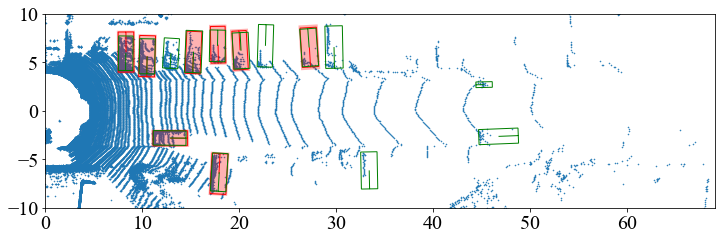

,y_true,conf,hull_lidar,hull_bev,X,Y,Z,Rot,W,L,...,sample_idx,angle,angle_gt,angle_deg,hull_lidar_ratio,hull_bev_ratio,RotCam,RotCamgt,Sigma_xy,distance
6669,1,0.813355,0.966731,1.667572,10.495852,5.651721,-0.857032,0.025183,1.630341,4.238662,...,2881,0.493949,0.492752,28.301216,0.094252,0.241311,0.519132,0.512752,0.0,11.920774
6670,1,0.800395,0.004543,0.162694,17.818785,6.836322,-0.650718,6.264931,1.522058,3.780922,...,2881,0.366340,0.361665,20.989717,0.000560,0.028271,0.348085,3.524850,0.0,19.085188
6671,1,0.797536,2.413580,4.283846,12.880201,-2.817310,-0.966412,4.709825,1.552763,3.538481,...,2881,-0.215340,-0.214457,-12.338092,0.317685,0.779672,4.494485,4.508728,0.0,13.184719
6672,1,0.774808,0.689655,1.190767,15.278002,6.030998,-0.748204,0.043239,1.556898,4.348069,...,2881,0.375973,0.380667,21.541649,0.066839,0.175902,0.419211,0.420667,0.0,16.425295
6673,1,0.739928,1.824754,3.140547,8.319537,6.078015,-0.904385,3.136055,1.608507,4.140368,...,2881,0.630950,0.623122,36.150791,0.187668,0.471567,3.767005,0.633122,0.0,10.303250
6674,1,0.697252,1.722132,3.777329,17.912796,-6.489748,-0.729936,3.194442,1.650276,4.175570,...,2881,-0.347587,-0.339228,-19.915287,0.167812,0.548166,2.846854,6.003957,0.0,19.052168
6675,1,0.599759,0.316998,0.627277,20.090712,6.263687,-0.731005,3.087318,1.485815,4.004300,...,2881,0.302220,0.298815,17.315926,0.037017,0.105431,3.389538,3.388815,0.0,21.044487
6676,1,0.474327,0.383009,0.873867,27.244219,6.568282,-0.680368,6.223715,1.695936,4.065195,...,2881,0.236574,0.236143,13.554714,0.035592,0.126752,0.177104,3.306143,0.0,28.024807


In [8]:
def annot2poly(X, Y, W, L, Rot):
    Rot = -Rot + np.pi
    poly = np.array([[X, Y], [X, Y + L/2], [X + W/2, Y + L/2], [X + W/2, Y - L/2], [X - W/2, Y - L/2], [X - W/2, Y + L/2], [X, Y + L/2]])
    poly = (poly - [X, Y]) @ np.array([[np.cos(Rot), np.sin(Rot)], [-np.sin(Rot), np.cos(Rot)]]) + [X, Y]
    return poly

def show_field(sub_df, show_img=True):
    if show_img:
        _fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    else:
        _fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        ax = [ax]
    
    assert sub_df.sample_idx.nunique() == 1
    show_index = sub_df.sample_idx.iloc[0]

    xlim = [0, 1]
    ylim = [0, 1]
    for _index, row in sub_df.iterrows():
        ax[0].add_patch(
            patches.Polygon(annot2poly(row.X, row.Y, row.W, row.L, row.Rot), closed=False, edgecolor='red', fill=False)
        )
        sigmaW = np.sqrt(row.varW)
        sigmaL = np.sqrt(row.varL)
        ax[0].add_patch(
            patches.Polygon(annot2poly(row.X, row.Y, row.W+sigmaW*2, row.L+sigmaL*2, row.Rot), closed=False, facecolor='red', alpha=0.3)
        )

        xlim[0] = min(xlim[0], row.X - row.W/2)
        xlim[1] = max(xlim[1], row.X + row.W/2)
        ylim[0] = min(ylim[0], row.Y - row.L/2)
        ylim[1] = max(ylim[1], row.Y + row.L/2)

    gt = gts[show_index]
    loc = gt["annos"]["location"]
    dims = gt["annos"]["dimensions"]
    rots = gt["annos"]["rotation_y"]
    gt_boxes_camera = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1)
    rect = gt["calib"]["R0_rect"]
    Trv2c = gt["calib"]["Tr_velo_to_cam"]
    gt_boxes_lidar = box_camera_to_lidar(gt_boxes_camera, rect, Trv2c)
    for Xgt, Ygt, _, Wgt, Lgt, _, Rotgt in gt_boxes_lidar:
        poly = annot2poly(Xgt, Ygt, Wgt, Lgt, Rotgt)
        ax[0].add_patch(
            patches.Polygon(poly, closed=False, edgecolor='green', fill=False)
        )

    v_path = os.path.join(os.path.dirname(os.path.abspath(KITTI_INFO)), gt["point_cloud"]["velodyne_path"])
    points_v = np.fromfile(
        v_path, dtype=np.float32, count=-1).reshape([-1, 4])
    ax[0].scatter(points_v[:,0], points_v[:,1], s=0.3)
    # ax[0].set_xlim(xlim[0], xlim[1])
    # ax[0].set_ylim(ylim[0], ylim[1])
    ax[0].set_xlim(0, 69.12)
    ax[0].set_ylim(-10, 10)
    ax[0].set_aspect('equal')

    if show_img:
        path = os.path.join(os.path.dirname(os.path.abspath(KITTI_INFO)), gt["image"]['image_path'])
        print(path)
        ax[1].imshow(np.asarray(Image.open(path)))

    plt.show()

sub_df = df[df.sample_idx == 2881]
show_field(sub_df, False)
sub_df

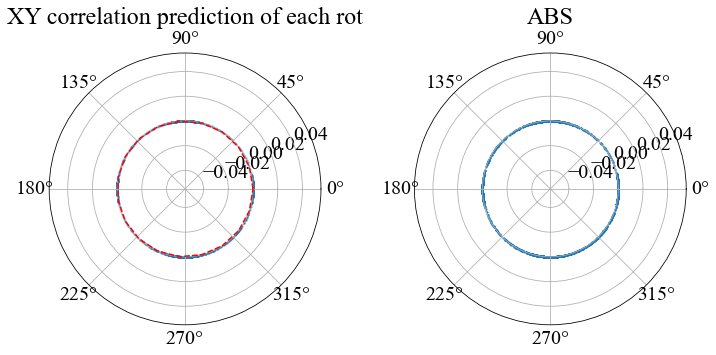

In [9]:
plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1, polar=True)
ax.set_title(f"XY correlation prediction of each rot")
ax.scatter(df.Rot, df.xy_correlation_pred, s=1, alpha=0.3)
ax.plot(np.linspace(0, np.pi*2, 20), np.zeros(20), "r--")

ax = plt.subplot(1,2,2, polar=True)
ax.set_title(f"ABS")
ax.scatter(df.Rot, np.abs(df.xy_correlation_pred), s=1)
plt.show()

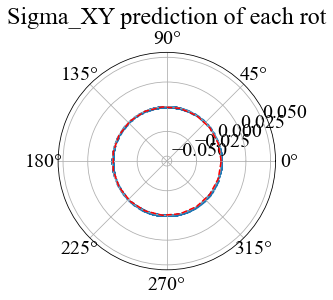

In [10]:
ax = plt.subplot(1,1,1, polar=True)
ax.set_title(f"Sigma_XY prediction of each rot")
ax.scatter(df.Rot, df.Sigma_xy, s=1)
ax.plot(np.linspace(0, np.pi*2, 20), np.zeros(20), "r--")
plt.show()

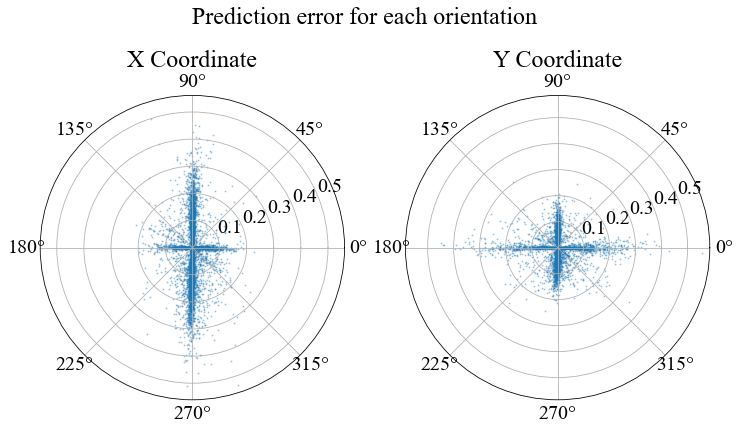

In [11]:
plt.figure(figsize=(12,7))
plt.suptitle("Prediction error for each orientation")
ax = plt.subplot(1,2,1, polar=True)
ax.set_title(f"X Coordinate")
ax.scatter(df.Rot, np.abs(df.X - df.Xgt), s=1, alpha=0.3)
ax.plot(np.linspace(0, np.pi*2, 20), np.zeros(20), "r--")

ax = plt.subplot(1,2,2, polar=True)
ax.set_title(f"Y Coordinate")
ax.scatter(df.Rot, np.abs(df.Y - df.Ygt), s=1, alpha=0.3)
plt.show()

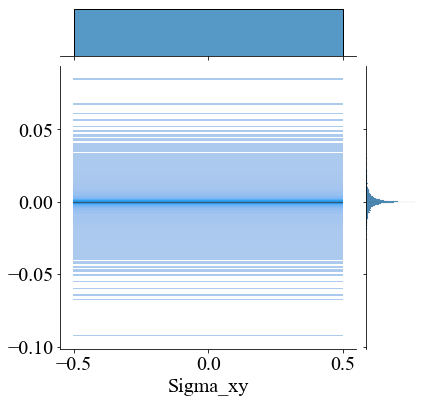

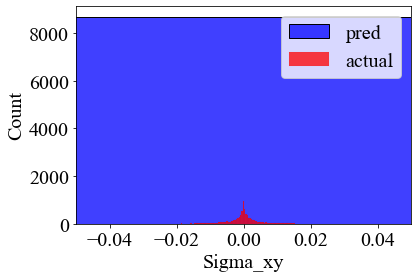

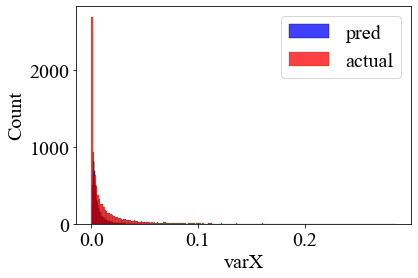

In [12]:
sns.jointplot(
    x=df.Sigma_xy,
    y=(df.X - df.Xgt) * (df.Y - df.Ygt),
    kind="hist")
plt.show()

sns.histplot(x=df.Sigma_xy, color="b", label="pred")
sns.histplot(x=(df.X - df.Xgt) * (df.Y - df.Ygt), color="r", label="actual")
plt.legend()
plt.xlim(-0.05, 0.05)
plt.show()

sns.histplot(x=df.varX, color="b", label="pred")
sns.histplot(x=(df.X - df.Xgt) ** 2, color="r", label="actual")
plt.legend()
plt.show()


明らかに傾いたbboxのX,Y lossの推定にはcorrelationが存在する

D-ECE: 0.15459097913153363


,0,1,2,3,4,5,6,7
0,0.157467,0.196193,0.155044,0.213299,0.171801,0.186278,0.147357,0.148692


ECE: 0.155690614843041
Sharpness: 1.805505e-05
3.0699126204696885 2.372770167487572
3.1083633961917974 2.3680514912134667
3.023495207466635 2.354150839076816
3.0731413666998018 2.3774751102912024
3.073180600445187 2.4067867753972902
3.084463407637826 2.378147872448659
3.046072071913743 2.379227249285001
3.0929834568656274 2.371566401760703
3.0829164261079463 2.3483819490884352
3.081259762130861 2.360596042411093
calibrated D-ECE: 0.04576451291259481


,0,1,2,3,4,5,6,7
0,0.037211,0.04014,0.044209,0.067292,0.015588,0.063852,0.051935,0.044898


calibrated ECE: 0.038752595260760817
calibrated Sharpness: 0.0001316189918253968


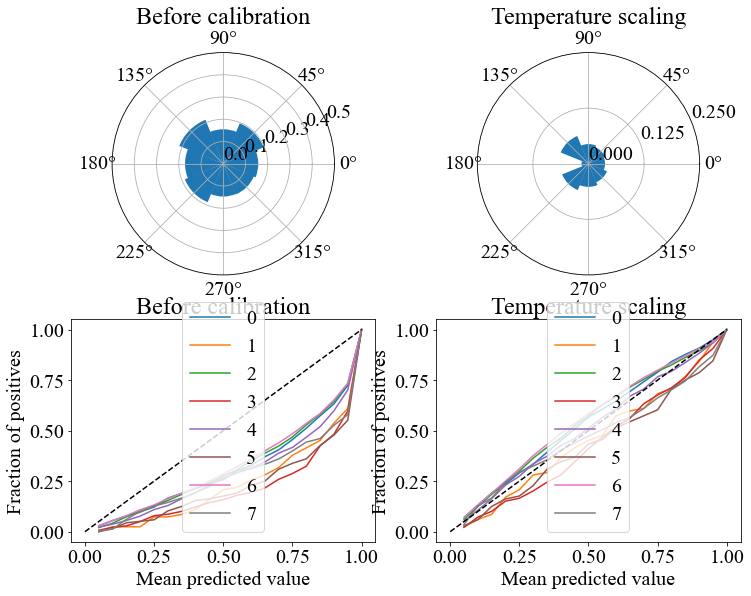

Sharpness for each angle [2.1090007e-05, 2.5128496e-05, 1.8360217e-05, 2.446341e-05, 2.088964e-05, 2.2522072e-05, 1.615315e-05, 2.0164713e-05]
Calibrated Sharpness for each angle [0.0001535770792761367, 0.00018323780104816077, 0.00013386758188957146, 0.00017742101433098928, 0.0001522337170108911, 0.00016435719078871692, 0.00011780852117065972, 0.00014689237987088033]


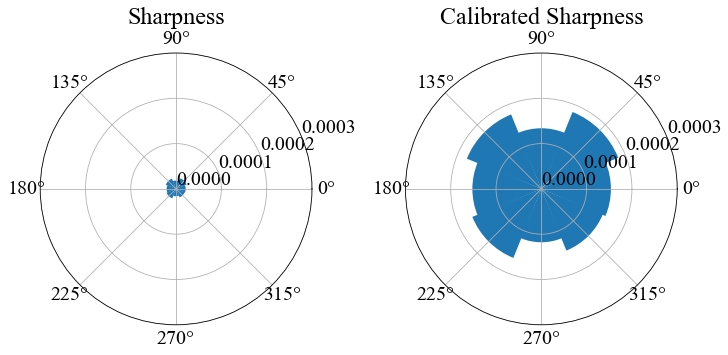

In [13]:
def make_cov(df):
    variance_pred = df[["varX", "varY"]].to_numpy()
    cov_pred = np.array([np.diag(variance) for variance in variance_pred])
    return cov_pred

def show(infer, cov_fn=make_cov):
    n_zbins = 8
    zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
    zbinids = np.digitize((df.Rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1

    plt.figure(figsize=(12,9))
    # plt.suptitle("(X, Y)-ECE of each rot")

    y_true = df[["Xgt", "Ygt"]].to_numpy()
    y_pred = df[["X", "Y"]].to_numpy()
    cov_pred = cov_fn(df)

    x = zbins[:n_zbins]
    eces = []
    sharps = []
    ax = plt.subplot(2,2,3)
    ax.set_title(f"Before calibration")
    for zi in range(n_zbins):
        prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], cov_pred[zbinids == zi], n_bins=20)
        eces.append((np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
        sharps.append(np.mean(np.linalg.det(cov_pred[zbinids == zi])))
        ax.plot(prob_pred, prob_true, label=str(zi))
    ax.legend()
    ax.set_xlabel("Mean predicted value")
    ax.set_ylabel("Fraction of positives")
    ax.plot([0,1], [0,1], "k--")
    ax.set_xlim(-0.05, 1.05)

    ax = plt.subplot(2,2,1, polar=True)
    ax.set_title(f"Before calibration")
    ax.bar(x, eces)
    ax.set_yticks(np.linspace(0.0, 0.5, 6, endpoint=True))
    ax.set_ylim(0, 0.5)
    print("D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
    display(pd.DataFrame(eces).T)
    prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true, y_pred, cov_pred, n_bins=20)
    print("ECE:", (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
    assert np.all(np.linalg.det(cov_pred) > 0)
    print("Sharpness:", np.mean(np.linalg.det(cov_pred)))

    kf = KFold(10, shuffle=False)

    y_trues = []
    y_preds = []
    calibed = []
    for train_idx, val_idx in kf.split(np.arange(len(df)), np.arange(len(df))):
        inst = infer(y_true[train_idx], y_pred[train_idx], cov_pred[train_idx], df.Rot.iloc[train_idx].to_numpy())
        calibed.append(inst(cov_pred[val_idx], df.Rot.iloc[val_idx].to_numpy()))
        y_trues.append(y_true[val_idx])
        y_preds.append(y_pred[val_idx])
    calibed = np.concatenate(calibed)
    y_true = np.concatenate(y_trues)
    y_pred = np.concatenate(y_preds)

    x = zbins[:n_zbins]
    eces = []
    calibed_sharps = []
    ax = plt.subplot(2,2,4)
    ax.set_title(f"Temperature scaling")
    for zi in range(n_zbins):
        prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], calibed[zbinids == zi], n_bins=20)
        eces.append((np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
        calibed_sharps.append(np.mean(np.linalg.det(calibed[zbinids == zi])))
        ax.plot(prob_pred, prob_true, label=str(zi))
    ax.legend()
    ax.set_xlabel("Mean predicted value")
    ax.set_ylabel("Fraction of positives")
    ax.plot([0,1], [0,1], "k--")
    ax.set_xlim(-0.05, 1.05)
    ax.legend()
    print("calibrated D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
    display(pd.DataFrame(eces).T)
    prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true, y_pred, calibed, n_bins=20)
    print("calibrated ECE:", (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
    assert np.all(np.linalg.det(calibed) > 0)
    print("calibrated Sharpness:", np.mean(np.linalg.det(calibed)))
    ax = plt.subplot(2,2,2, polar=True)
    ax.set_title(f"Temperature scaling")
    ax.bar(x, eces)
    ax.set_yticks(np.linspace(0.0, 0.25, 3))
    ax.set_ylim(0, 0.25)
    plt.show()

    plt.figure(figsize=(12,5))
    ax = plt.subplot(1,2,1, polar=True)
    ax.set_title("Sharpness")
    ax.bar(x, sharps)
    print("Sharpness for each angle", sharps)
    ax.set_ylim(0, 3e-4)
    ax.set_yticks(np.linspace(0.0, 3e-4, 4, endpoint=True))
    ax = plt.subplot(1,2,2, polar=True)
    ax.set_title("Calibrated Sharpness")
    ax.bar(x, calibed_sharps)
    print("Calibrated Sharpness for each angle", calibed_sharps)
    ax.set_ylim(0, 3e-4)
    ax.set_yticks(np.linspace(0.0, 3e-4, 4, endpoint=True))
    plt.show()

def model(gt, pred, cov, rot):
    # method = "scaling"
    method = "nll"

    if method == "scaling":
        invT0 = np.sum((gt[:,0] - pred[:,0]) ** 2) / cov[:,0,0].sum()
        invT1 = np.sum((gt[:,1] - pred[:,1]) ** 2) / cov[:,1,1].sum()
    elif method == "nll":
        invT0 = np.mean((gt[:,0] - pred[:,0]) ** 2 / cov[:,0,0])
        invT1 = np.mean((gt[:,1] - pred[:,1]) ** 2 / cov[:,1,1])
    print(invT0, invT1)
    return (lambda cov, rot: np.array([v @ np.diag([invT0, invT1]) for v in cov]))
show(model)


D-ECE: 0.15459097913153363


,0,1,2,3,4,5,6,7
0,0.157467,0.196193,0.155044,0.213299,0.171801,0.186278,0.147357,0.148692


ECE: 0.155690614843041
Sharpness: 1.8055050448550406e-05
     fun: 0.010666544494194354
    nfev: 33
     nit: 29
 success: True
       x: 0.8115285199564318
     fun: 0.012217420895460154
    nfev: 36
     nit: 32
 success: True
       x: 0.8121866089198803
     fun: 0.01210200700063085
    nfev: 37
     nit: 33
 success: True
       x: 0.7926424983855792
     fun: 0.01067768205597352
    nfev: 30
     nit: 26
 success: True
       x: 0.8008587988982186
     fun: 0.011247688392684072
    nfev: 36
     nit: 32
 success: True
       x: 0.8250784195838163
     fun: 0.01121576488474795
    nfev: 30
     nit: 26
 success: True
       x: 0.80905646900059
     fun: 0.010940187645504222
    nfev: 33
     nit: 29
 success: True
       x: 0.8153685749219338
     fun: 0.009446256545132255
    nfev: 35
     nit: 31
 success: True
       x: 0.8155951149615132
     fun: 0.011215871108144806
    nfev: 30
     nit: 26
 success: True
       x: 0.8098892425091306
     fun: 0.011377849465516324
    nfev

,0,1,2,3,4,5,6,7
0,0.008872,0.081454,0.011178,0.109862,0.028264,0.101633,0.016904,0.061061


calibrated ECE: 0.011320978587541082
calibrated Sharpness: 9.133901848848897e-05


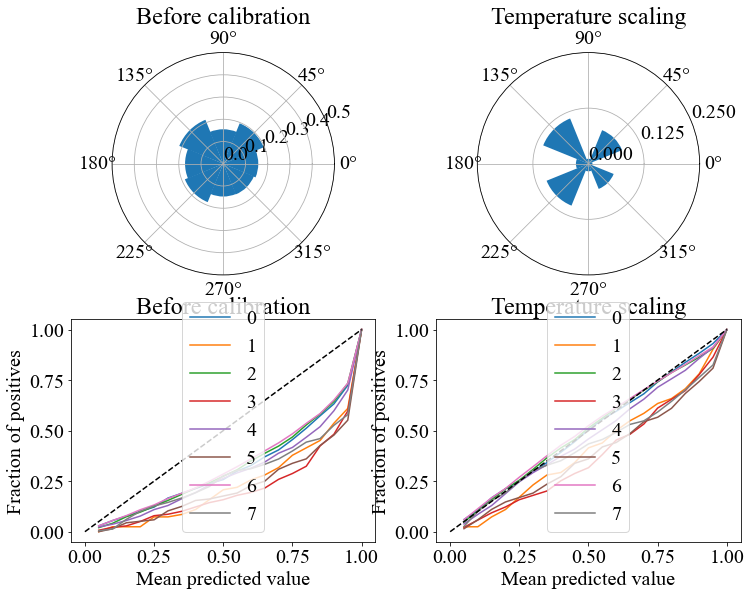

Sharpness for each angle [2.109000733907706e-05, 2.5128499727127694e-05, 1.8360217044042343e-05, 2.446340975268478e-05, 2.0889639742669165e-05, 2.2522070976548456e-05, 1.615315028291477e-05, 2.016471263386115e-05]
Calibrated Sharpness for each angle [0.00010663768984140565, 0.00012728398918236434, 9.289314451379493e-05, 0.0001229310285525491, 0.00010561245957217753, 0.00011384819244273752, 8.175440392099297e-05, 0.00010210793333484787]


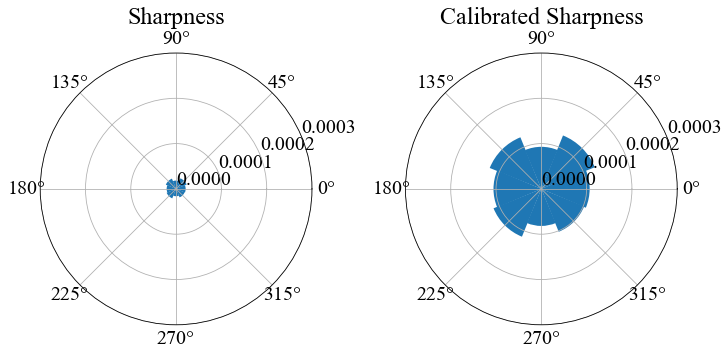

In [14]:
def make_cov_corr(df):
    variance_pred = df[["varX", "varY"]].to_numpy()
    corr = df.xy_correlation_pred.to_numpy()
    cov_pred = np.array([
        np.array([
            [vx, np.sqrt(vx * vy) * c],
            [np.sqrt(vx * vy) * c, vy],
        ])
        for (vx, vy), c in zip(variance_pred, corr)])
    return cov_pred

def model_corr(gt, pred, cov, rot):
    method = "optim"
    # method = "scaling"
    # method = "mahalanobis"
    # method = "nll"

    if method == "scaling":
        invT0 = np.sum((gt[:,0] - pred[:,0]) ** 2) / cov[:,0,0].sum()
        invT1 = np.sum((gt[:,1] - pred[:,1]) ** 2) / cov[:,1,1].sum()
        invT01 = np.sqrt(invT0 * invT1)
        # invT0 = invT01
        # invT1 = invT01
    elif method == "mahalanobis":
        diff = gt - pred
        maha = (diff[:,None,:] @ np.linalg.inv(cov) @ diff[:,:,None]).ravel()
        invT01 = maha.mean()/2
        invT0 = invT01
        invT1 = invT01
    elif method == "nll":
        invT0 = np.mean((gt[:,0] - pred[:,0]) ** 2 / cov[:,0,0])
        invT1 = np.mean((gt[:,1] - pred[:,1]) ** 2 / cov[:,1,1])
        invT01 = np.sqrt(invT0 * invT1)
    elif method == "optim":
        def fn(loginvT):
            invT = np.exp(loginvT)
            prob_true, prob_pred, counts = reg_calibration_curve_nd(gt, pred, cov * invT, 20)
            return (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum()
        result = minimize_scalar(fn)
        print(result)
        invT01 = np.exp(result.x)
        invT0 = invT01
        invT1 = invT01
    return (lambda cov, rot: np.array([v * np.array([[invT0, invT01], [invT01, invT1]]) for v in cov]))

show(model_corr, cov_fn=make_cov_corr)

D-ECE: 0.15459097913153363


,0,1,2,3,4,5,6,7
0,0.157467,0.196193,0.155044,0.213299,0.171801,0.186278,0.147357,0.148692


ECE: 0.155690614843041
Sharpness: 1.8055050448550406e-05
2.1020607890167238 2.8023707024524445
3.268226131569319 3.115684131647982
2.8811547929079744 2.5897365168081796
4.340665129220082 2.8032741499477987
2.2255698682409686 3.243542050109718
3.90139290344543 3.7456332640531116
3.4269215869043395 1.8615577848729488
3.513334960176718 3.1084938121093653
2.014112656869393 2.791088634328449
3.30600049240092 2.894992704570608
2.9392892207680754 2.576016170030946
4.147566185627417 2.650700208915512
2.1722349180055156 3.373821429625973
3.8148412540466032 4.0130062376277325
3.489233933345589 1.8449465722194929
3.7329607985106654 3.3469423022754916
2.1178906177858723 2.81464737885474
3.348945524723099 3.2334565188788766
2.7815918797027397 2.564671024436572
4.4687675520952395 2.9271697899306384
2.0798062913743647 3.2639702073735934
4.23603342119061 3.7824081788370125
3.3744166585400275 1.8367587271080434
3.7974745661063523 3.2074657176565347
2.112167460857975 2.918519686710931
3.395569282363601 

,0,1,2,3,4,5,6,7
0,0.020198,0.018739,0.045578,0.019362,0.020827,0.026784,0.035851,0.037219


calibrated ECE: 0.035033498968060225
calibrated Sharpness: 0.00013101487125091244


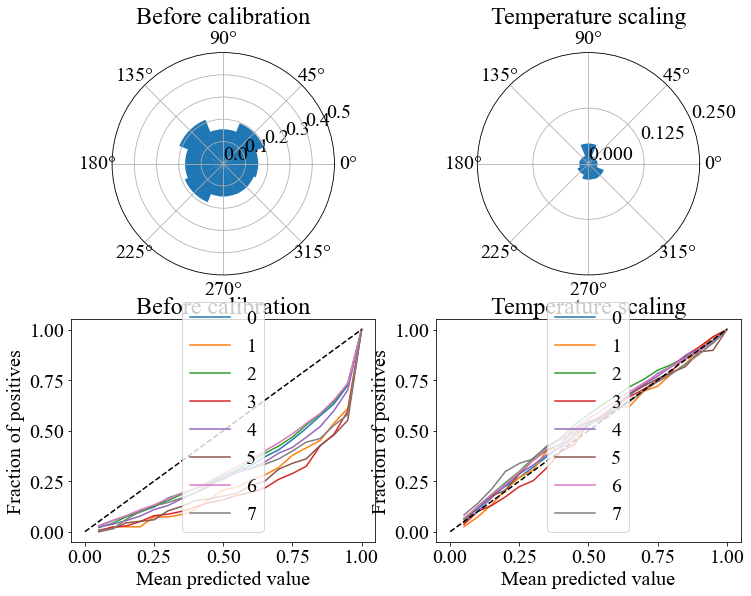

Sharpness for each angle [2.109000733907706e-05, 2.5128499727127694e-05, 1.8360217044042343e-05, 2.446340975268478e-05, 2.0889639742669165e-05, 2.2522070976548456e-05, 1.615315028291477e-05, 2.016471263386115e-05]
Calibrated Sharpness for each angle [0.00012481066441365172, 0.0002608957497892969, 0.00013510143201965878, 0.0003045786520213752, 0.00015229503311926, 0.00034708815331130246, 0.00010303190458456206, 0.000243493298822054]


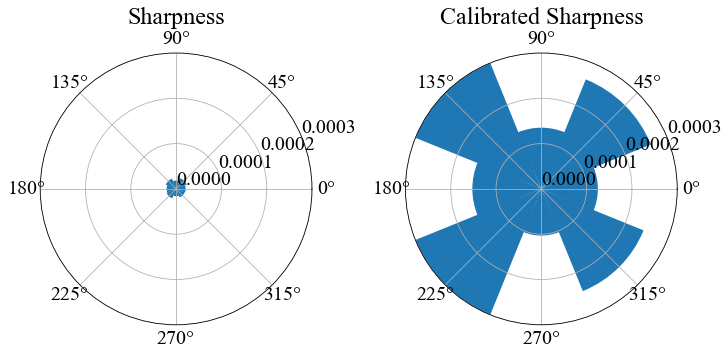

In [15]:
def model_rot(gt, pred, cov, rot):
    # method = "optim"
    method = "nll"

    n_zbins = 8
    zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
    zbinids = np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
    if method == "optim":
        invTs = np.zeros(n_zbins)
        def fn(loginvT, _gt, _pred, _cov):
            invT = np.exp(loginvT)
            prob_true, prob_pred, counts = reg_calibration_curve_nd(_gt, _pred, _cov * invT, 20)
            return (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum()

        for zi in range(n_zbins):
            result = minimize_scalar(
                fn,
                args=(gt[zbinids == zi], pred[zbinids == zi], cov[zbinids == zi]),
            )
            invTs[zi] = np.exp(result.x)
        return (lambda cov, rot: np.array([v * invTs[zi] for v, zi in zip(cov, np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1)]))
    elif method == "nll":
        mods = []
        for zi in range(n_zbins):
            mod = model(gt[zbinids == zi], pred[zbinids == zi], cov[zbinids == zi], rot[zbinids == zi])
            mods.append(mod)
        return (lambda cov, rot: np.array([mods[zi](v, r) for v, r, zi in zip(cov, rot, np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1)]))

show(model_rot, cov_fn=make_cov_corr)


D-ECE: 0.15459097913153363


,0,1,2,3,4,5,6,7
0,0.157467,0.196193,0.155044,0.213299,0.171801,0.186278,0.147357,0.148692


ECE: 0.155690614843041
Sharpness: 1.8055050448550406e-05
2.1312797976999174 3.2500163444783605
2.0995148962094503 3.315674213021003
2.09319671354865 3.222499225073363
2.0953588103297953 3.294037165701419
2.123001808314446 3.2924551542409524
2.1127419030875356 3.2862754660440316
2.1197911185249176 3.2392720157011676
2.1098515183527837 3.2872368882648946
2.075215088154824 3.2926881651805497
2.1132272259119294 3.2659425440959367
calibrated D-ECE: 0.04085592747242598


,0,1,2,3,4,5,6,7
0,0.038682,0.036466,0.037486,0.072056,0.015079,0.060759,0.046051,0.038943


calibrated ECE: 0.0342179851355959
calibrated Sharpness: 0.00012459461057291957


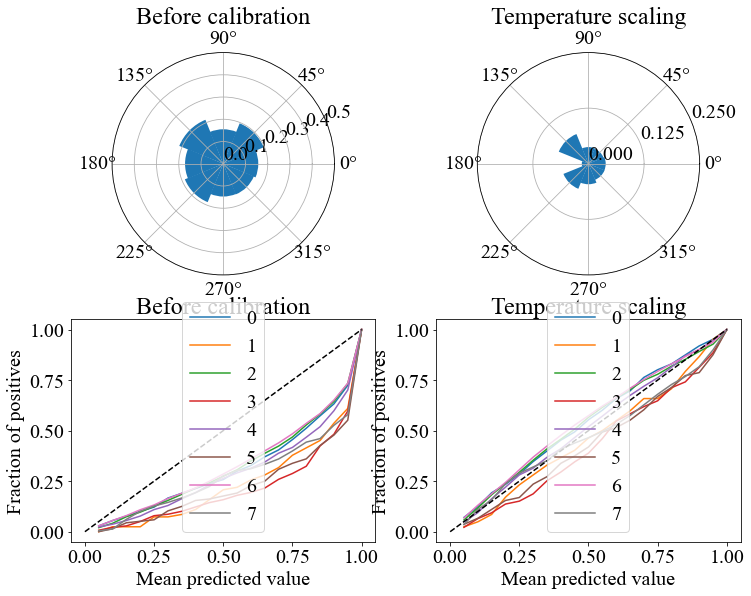

Sharpness for each angle [2.109000733907706e-05, 2.5128499727127694e-05, 1.8360217044042343e-05, 2.446340975268478e-05, 2.0889639742669165e-05, 2.2522070976548456e-05, 1.615315028291477e-05, 2.016471263386115e-05]
Calibrated Sharpness for each angle [0.00014534348730457433, 0.00017342915101567998, 0.0001267246336793937, 0.00016790461934484884, 0.00014409669992964693, 0.00015561365700594057, 0.00011153481986099869, 0.0001389819712856211]


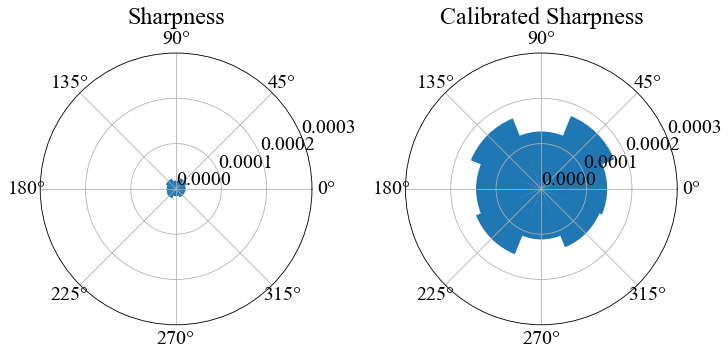

In [16]:
def model_rot2(gt, pred, cov, rot):
    rmat = lambda r: np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])

    rcov = np.array([rmat(r) @ c @ rmat(-r) for c,r in zip(cov, rot)])
    rpred = np.array([(p - g) @ rmat(r) + g for p,g,r in zip(pred, gt, rot)])
    mod = model(gt, rpred, rcov, rot)
    return (lambda cov, rot: np.array([rmat(r) @ mod([rmat(-r) @ c @ rmat(r)], [r])[0] @ rmat(-r) for c, r in zip(cov, rot)]))

show(model_rot2, cov_fn=make_cov_corr)


D-ECE: 0.15459097913153363


,0,1,2,3,4,5,6,7
0,0.157467,0.196193,0.155044,0.213299,0.171801,0.186278,0.147357,0.148692


ECE: 0.155690614843041
Sharpness: 1.8055050448550406e-05
2.0510191792597317 2.8216384124156795
2.0600690095607193 3.7104155501538862
2.5102475643923574 2.906097430740912
3.4703522595598852 3.3535216923490245
2.091300146924299 3.292227288655639
2.2052474200919856 4.826219437441113
1.848868699042026 3.430264927063451
1.6831154659478058 4.589690541152042
1.9521690488351449 2.8157785261824144
2.081293556899729 3.4709129186444074
2.4974548681028583 2.9648102825528433
3.4903523828245833 3.0624140441527428
2.023559771748992 3.4291443935958705
2.2666004049969515 4.965567230027952
1.8283085231985514 3.4943417298699178
1.6536400017174313 5.06644196389865
2.0671512506595207 2.832274921152151
2.008016061764158 3.936104089555948
2.5036494892419423 2.8019764927478636
3.4711185715988986 3.491697958327335
1.9044041911096732 3.327375397043228
2.0480290771764804 5.360658885880146
1.810138535183038 3.385562061119198
1.6399311116201638 5.028817647343796
2.054404021202762 2.941632905915305
2.04467071411189

,0,1,2,3,4,5,6,7
0,0.017706,0.028941,0.04314,0.015649,0.015329,0.016804,0.035464,0.026831


calibrated ECE: 0.0320166622891865
calibrated Sharpness: 0.00012430751599084376


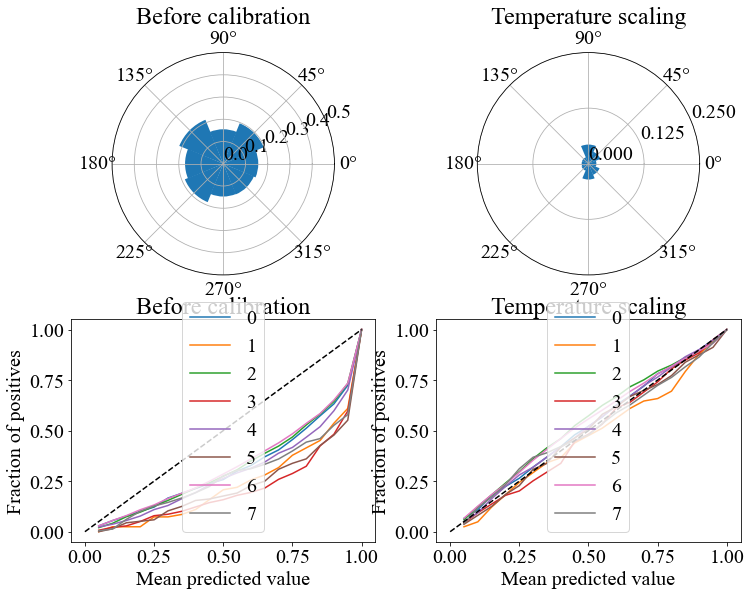

Sharpness for each angle [2.109000733907706e-05, 2.5128499727127694e-05, 1.8360217044042343e-05, 2.446340975268478e-05, 2.0889639742669165e-05, 2.2522070976548456e-05, 1.615315028291477e-05, 2.016471263386115e-05]
Calibrated Sharpness for each angle [0.0001223930882786013, 0.00019205893352678666, 0.00013220628560231337, 0.0002874122146079655, 0.0001441478618797881, 0.0002443344052987102, 0.0001022178913268615, 0.0001638669417560498]


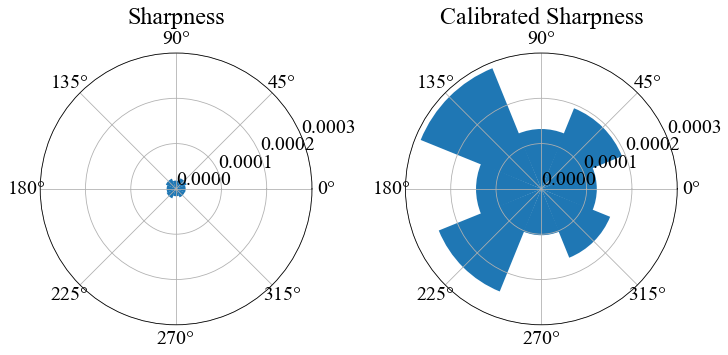

In [17]:
def model_rot3(gt, pred, cov, rot):
    rmat = lambda r: np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])
    rcov = np.array([rmat(r) @ c @ rmat(-r) for c,r in zip(cov, rot)])
    rpred = np.array([(p - g) @ rmat(r) + g for p,g,r in zip(pred, gt, rot)])

    n_zbins = 8
    zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
    zbinids = np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
    mods = [None for _ in range(n_zbins)]

    for zi in range(n_zbins):
        mods[zi] = model(gt[zbinids == zi], rpred[zbinids == zi], rcov[zbinids == zi], rot[zbinids == zi])

    return (lambda cov, rot: np.array([rmat(r) @ mods[zi]([rmat(-r) @ c @ rmat(r)], [r])[0] @ rmat(-r) for c, r, zi in zip(cov, rot, np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1)]))

show(model_rot3, cov_fn=make_cov_corr)


## Isotonic

In [18]:
# n_zbins = 8
# zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
# zbinids = np.digitize((df.Rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1

# plt.figure(figsize=(12,9))
# # plt.suptitle("(X, Y)-ECE of each rot")

# y_true = df[["Xgt", "Ygt"]].to_numpy()
# y_pred = df[["X", "Y"]].to_numpy()
# cov_pred = np.array([np.diag(variance) for variance in zip(df.varX, df.varY)])

# x = zbins[:n_zbins]
# eces = []
# sharps = []
# ax = plt.subplot(2,2,3)
# ax.set_title(f"Before calibration")
# for zi in range(n_zbins):
#     prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], cov_pred[zbinids == zi], n_bins=20)
#     eces.append((np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
#     sharps.append(np.mean(np.linalg.det(cov_pred[zbinids == zi])))
#     ax.plot(prob_pred, prob_true, label=str(zi))
# ax.legend()
# ax.set_xlabel("Mean predicted value")
# ax.set_ylabel("Fraction of positives")
# ax.plot([0,1], [0,1], "k--")
# ax.set_xlim(-0.05, 1.05)

# ax = plt.subplot(2,2,1, polar=True)
# ax.set_title(f"Before calibration")
# ax.bar(x, eces)
# ax.set_yticks(np.linspace(0.0, 0.5, 6, endpoint=True))
# ax.set_ylim(0, 0.5)
# print("D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
# display(pd.DataFrame(eces).T)
# prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true, y_pred, cov_pred, n_bins=20)
# print("ECE:", (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
# assert np.all(np.linalg.det(cov_pred) > 0)
# print("Sharpness:", np.mean(np.linalg.det(cov_pred)))

# kf = KFold(10, shuffle=False)

# y_trues = []
# y_preds = []
# calibed = []
# for train_idx, val_idx in kf.split(np.arange(len(df)), np.arange(len(df))):
#     inst = infer(y_true[train_idx], y_pred[train_idx], cov_pred[train_idx], df.Rot.iloc[train_idx].to_numpy())
#     calibed.append(inst(cov_pred[val_idx], df.Rot.iloc[val_idx].to_numpy()))
#     y_trues.append(y_true[val_idx])
#     y_preds.append(y_pred[val_idx])
# calibed = np.concatenate(calibed)
# y_true = np.concatenate(y_trues)
# y_pred = np.concatenate(y_preds)

# x = zbins[:n_zbins]
# eces = []
# calibed_sharps = []
# ax = plt.subplot(2,2,4)
# ax.set_title(f"Temperature scaling")
# for zi in range(n_zbins):
#     prob_true, prob_pred = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], calibed[zbinids == zi], n_bins=20)
#     eces.append(np.abs(prob_true - prob_pred).mean())
#     calibed_sharps.append(np.mean(np.linalg.det(calibed[zbinids == zi])))
#     ax.plot(prob_pred, prob_true, label=str(zi))
# ax.legend()
# ax.set_xlabel("Mean predicted value")
# ax.set_ylabel("Fraction of positives")
# ax.plot([0,1], [0,1], "k--")
# ax.set_xlim(-0.05, 1.05)
# ax.legend()
# print("calibrated D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
# display(pd.DataFrame(eces).T)
# prob_true, prob_pred = reg_calibration_curve_nd(y_true, y_pred, calibed, n_bins=20)
# print("calibrated ECE:", np.abs(prob_true - prob_pred).mean())
# assert np.all(np.linalg.det(calibed) > 0)
# print("calibrated Sharpness:", np.mean(np.linalg.det(calibed)))
# ax = plt.subplot(2,2,2, polar=True)
# ax.set_title(f"Temperature scaling")
# ax.bar(x, eces)
# ax.set_yticks(np.linspace(0.0, 0.25, 3))
# ax.set_ylim(0, 0.25)
# plt.show()

# plt.figure(figsize=(12,5))
# ax = plt.subplot(1,2,1, polar=True)
# ax.set_title("Sharpness")
# ax.bar(x, sharps)
# print("Sharpness for each angle", sharps)
# ax.set_ylim(0, 3e-4)
# ax.set_yticks(np.linspace(0.0, 3e-4, 4, endpoint=True))
# ax = plt.subplot(1,2,2, polar=True)
# ax.set_title("Calibrated Sharpness")
# ax.bar(x, calibed_sharps)
# print("Calibrated Sharpness for each angle", calibed_sharps)
# ax.set_ylim(0, 3e-4)
# ax.set_yticks(np.linspace(0.0, 3e-4, 4, endpoint=True))
# plt.show()

## Everything

In [19]:
def calibreg(name, featall=True, show_img=True, return_imp=False):
    CV = 10

    kf = KFold(CV, shuffle=False)
    X = np.arange(df.sample_idx.max()+1)
    calibed_true = []
    calibed_pred = []
    indices = []
    imp = []

    for train_idx, val_idx in kf.split(X, X):
        trainset = df[df.sample_idx.isin(train_idx)]
        valset = df[df.sample_idx.isin(val_idx)]
        indices.append(valset.index.to_numpy())
        calibed_true.append(valset[name].to_numpy())

        if featall:
            X_train = np.vstack([
                logit(trainset.conf.to_numpy()),
                trainset.hull_bev_ratio.to_numpy(),
                np.cos(trainset.angle.to_numpy()), np.sin(trainset.angle.to_numpy()),
                trainset.distance.to_numpy(),
                trainset.Y.to_numpy(),
                trainset.W.to_numpy(),
                trainset.L.to_numpy(),
                trainset.H.to_numpy(),
                np.cos(trainset.Rot.to_numpy()), np.sin(trainset.Rot.to_numpy()),
                np.sin(2*trainset.Rot.to_numpy())**2,
                np.log(trainset.varX.to_numpy()),
                np.log(trainset.varY.to_numpy()),
                np.log(trainset.varZ.to_numpy()),
                np.log(trainset.varL.to_numpy()),
                np.log(trainset.varH.to_numpy()),
                np.log(trainset.varW.to_numpy()),
                np.log(trainset.varRot.to_numpy()),
            ]).T
            X_val = np.vstack([
                logit(valset.conf.to_numpy()),
                valset.hull_bev_ratio.to_numpy(),
                np.cos(valset.angle.to_numpy()), np.sin(valset.angle.to_numpy()),
                valset.distance.to_numpy(),
                valset.Y.to_numpy(),
                valset.W.to_numpy(),
                valset.L.to_numpy(),
                valset.H.to_numpy(),
                np.cos(valset.Rot.to_numpy()), np.sin(valset.Rot.to_numpy()),
                np.sin(2*valset.Rot.to_numpy())**2,
                np.log(valset.varX.to_numpy()),
                np.log(valset.varY.to_numpy()),
                np.log(valset.varZ.to_numpy()),
                np.log(valset.varL.to_numpy()),
                np.log(valset.varH.to_numpy()),
                np.log(valset.varW.to_numpy()),
                np.log(valset.varRot.to_numpy()),
            ]).T
        else:
            X_train = np.log(trainset["var" + name].to_numpy()[:,None])
            X_val = np.log(valset["var" + name].to_numpy()[:,None])

        if name == "Rot":
            y_train = ((trainset[name].to_numpy() - trainset[name + "gt"].to_numpy()) % (2*np.pi)) ** 2
            y_val = ((valset[name].to_numpy() - valset[name + "gt"].to_numpy()) % (2*np.pi)) ** 2
        else:
            y_train = (trainset[name].to_numpy() - trainset[name + "gt"].to_numpy()) ** 2
            y_val = (valset[name].to_numpy() - valset[name + "gt"].to_numpy()) ** 2

        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('estimator', GammaRegressor())
        ])
        inst = pipe.fit(X_train, y_train)
        calibed_pred.append(inst.predict(X_val))
        imp.append(pipe.steps[1][1].coef_)

    calibed_true = np.concatenate(calibed_true)
    calibed_pred = np.concatenate(calibed_pred)
    indices = np.concatenate(indices)
    if featall:
        feature = (
            "uncalib. logit", "convex hull IoU", "cos(angle)", "sin(angle)", "distance", "Z coordinate", "width", "length", "height", "cos(heading)", "sin(heading)",
            "sin(2*heading)^2",
            "logvarX", "logvarY", "logvarZ", "logvarL", "logvarH", "logvarW", "logvarRot")
    else:
        feature = ("logvar" + name,)

    if show_img:
        fig, ax = plt.subplots(figsize=(7,7))
        ax.barh(np.arange(len(feature)), np.mean(imp, axis=0), xerr=np.std(imp, axis=0, ddof=1))
        ax.set_yticks(np.arange(len(feature)))
        ax.set_yticklabels(feature)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Coefficient')
        ax.grid(True)
        plt.show()
    if return_imp:
        return calibed_pred, feature, np.mean(imp, axis=0)
    return calibed_pred

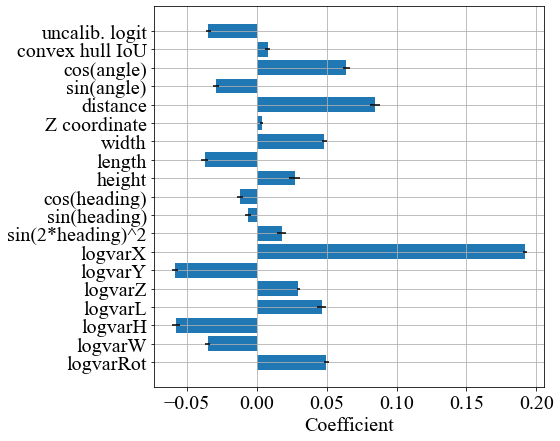

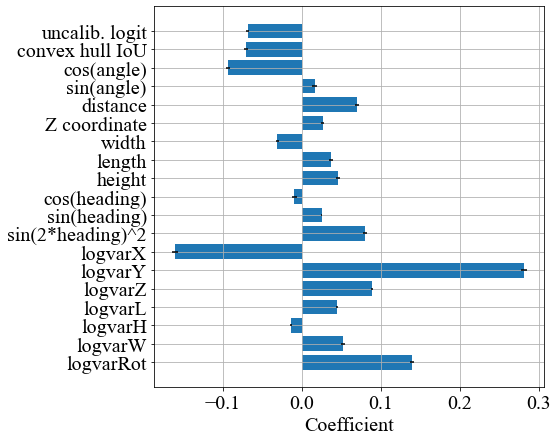

calibrated D-ECE: 0.027556848629675536


,0,1,2,3,4,5,6,7
0,0.02275,0.030577,0.026992,0.027579,0.028033,0.022794,0.028389,0.036923


calibrated ECE: 0.022658745053362905
calibrated Sharpness: 6.319496303479524e-05


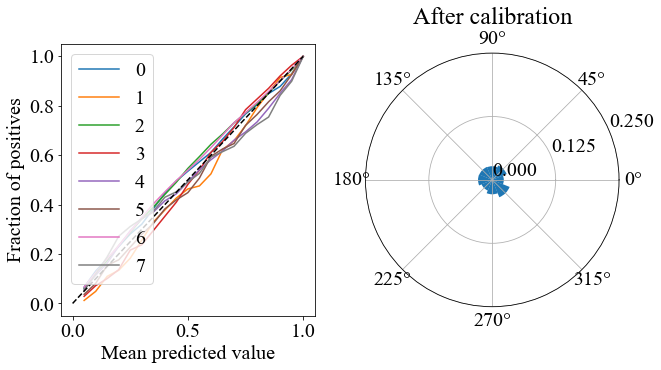

In [20]:
calibedX = calibreg("X")
calibedY = calibreg("Y")

n_zbins = 8
zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
zbinids = np.digitize((df.Rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
x = zbins[:n_zbins]

y_true = df[["Xgt", "Ygt"]].to_numpy()
y_pred = df[["X", "Y"]].to_numpy()
calibed = np.array([np.diag(variance) for variance in zip(calibedX, calibedY)])

plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2,1)
eces = []
calibed_sharps = []
for zi in range(n_zbins):
    prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], calibed[zbinids == zi], n_bins=20)
    eces.append((np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
    calibed_sharps.append(np.mean(np.linalg.det(calibed[zbinids == zi])))
    ax.plot(prob_pred, prob_true, label=str(zi))
ax.legend()
ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.plot([0,1], [0,1], "k--")
ax.set_xlim(-0.05, 1.05)
ax.legend()
print("calibrated D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
display(pd.DataFrame(eces).T)
prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true, y_pred, calibed, n_bins=20)
print("calibrated ECE:", (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
assert np.all(np.linalg.det(calibed) > 0)
print("calibrated Sharpness:", np.mean(np.linalg.det(calibed)))
ax = plt.subplot(1,2,2, polar=True)
ax.set_title(f"After calibration")
ax.bar(x, eces)
ax.set_yticks(np.linspace(0.0, 0.25, 3))
ax.set_ylim(0, 0.25)
plt.show()

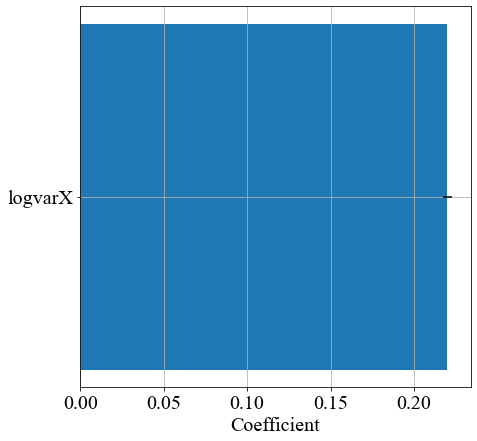

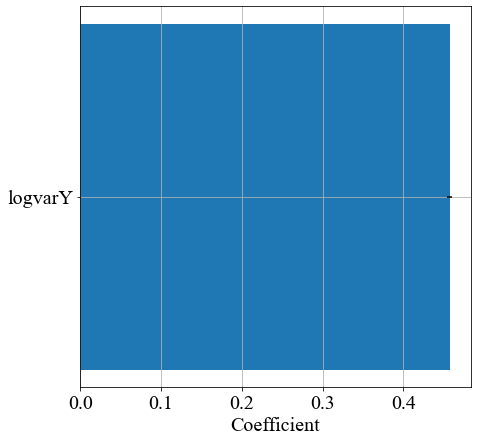

calibrated D-ECE: 0.04621112755160607


,0,1,2,3,4,5,6,7
0,0.021592,0.073855,0.046747,0.064213,0.041424,0.062435,0.049683,0.04446


calibrated ECE: 0.033961107733369876
calibrated Sharpness: 5.884262481783702e-05


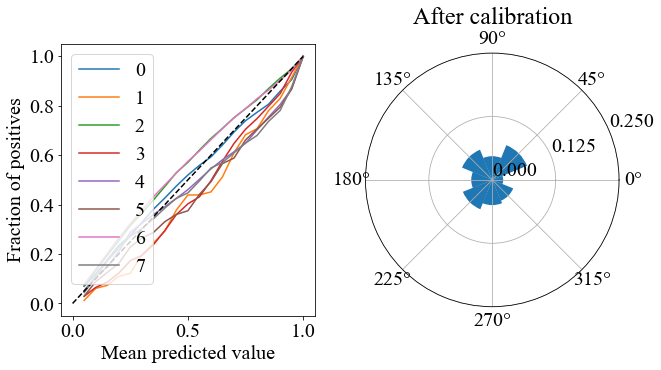

In [21]:
calibedX = calibreg("X", False)
calibedY = calibreg("Y", False)

n_zbins = 8
zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
zbinids = np.digitize((df.Rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
x = zbins[:n_zbins]

y_true = df[["Xgt", "Ygt"]].to_numpy()
y_pred = df[["X", "Y"]].to_numpy()
calibed = np.array([np.diag(variance) for variance in zip(calibedX, calibedY)])

plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2,1)
eces = []
calibed_sharps = []
for zi in range(n_zbins):
    prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], calibed[zbinids == zi], n_bins=20)
    eces.append((np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
    calibed_sharps.append(np.mean(np.linalg.det(calibed[zbinids == zi])))
    ax.plot(prob_pred, prob_true, label=str(zi))
ax.legend()
ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.plot([0,1], [0,1], "k--")
ax.set_xlim(-0.05, 1.05)
ax.legend()
print("calibrated D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
display(pd.DataFrame(eces).T)
prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true, y_pred, calibed, n_bins=20)
print("calibrated ECE:", (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
assert np.all(np.linalg.det(calibed) > 0)
print("calibrated Sharpness:", np.mean(np.linalg.det(calibed)))
ax = plt.subplot(1,2,2, polar=True)
ax.set_title(f"After calibration")
ax.bar(x, eces)
ax.set_yticks(np.linspace(0.0, 0.25, 3))
ax.set_ylim(0, 0.25)
plt.show()

In [22]:
names = ["X", "Y", "Z", "L", "H", "W", "Rot"]
calibed, feats, imps = list(zip(*[calibreg(n, show_img=False, return_imp=True) for n in names]))

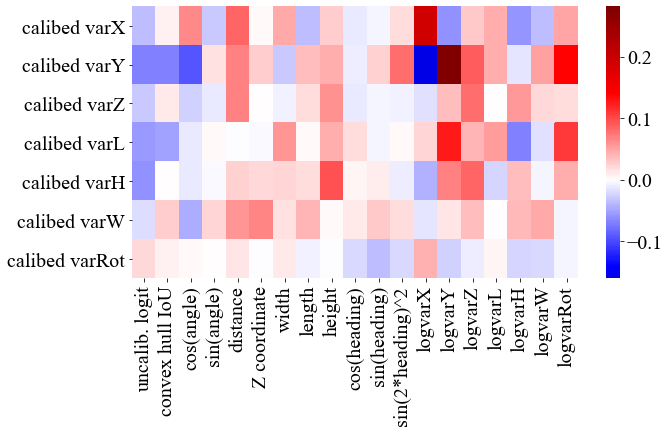

In [23]:
plt.figure(figsize=(10, 5))
sns.heatmap(imps, xticklabels=feats[0], yticklabels=["calibed var" + n for n in names], cmap="seismic", center=0)
plt.show()

## Everything with rot

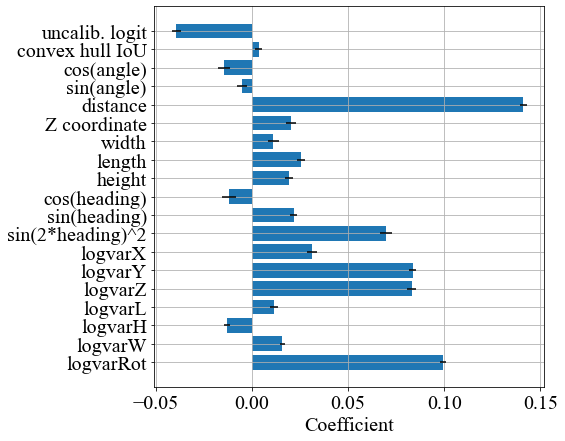

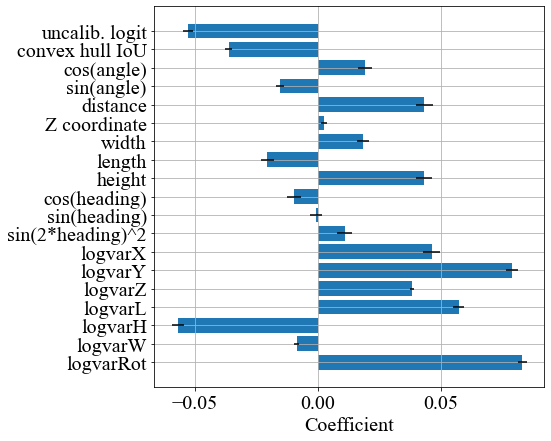

calibrated D-ECE: 0.018797001501308613


,0,1,2,3,4,5,6,7
0,0.010674,0.030235,0.019215,0.049097,0.012012,0.023756,0.019636,0.018613


calibrated ECE: 0.014031594195076073
calibrated Sharpness: 5.231900398402014e-05


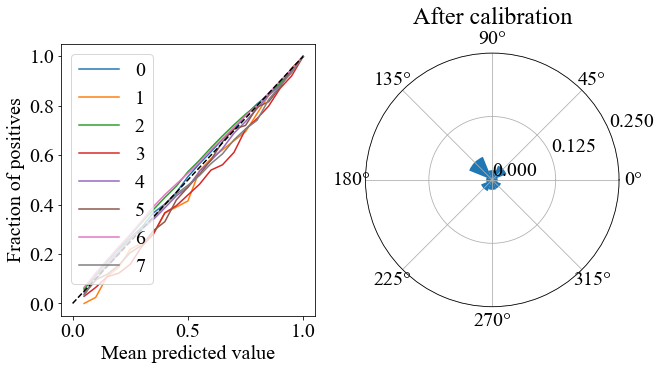

In [25]:
rmat = lambda r: np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])
y_true = df[["Xgt", "Ygt"]].to_numpy()
y_pred = df[["X", "Y"]].to_numpy()
rot = df.Rot.to_numpy()
rpred = np.array([(p - g) @ rmat(r) + g for p,g,r in zip(y_pred, y_true, rot)])
rcalib = []

for coord in range(2):
    CV = 10

    kf = KFold(CV, shuffle=False)
    X = np.arange(df.sample_idx.max()+1)
    calibed_true = []
    calibed_pred = []
    indices = []
    imp = []

    for train_idx, val_idx in kf.split(X, X):
        trainmask = df.sample_idx.isin(train_idx)
        valmask = df.sample_idx.isin(val_idx)
        trainset = df[trainmask]
        valset = df[valmask]
        indices.append(valset.index.to_numpy())
        calibed_true.append(rpred[valmask, coord])

        X_train = np.vstack([
            logit(trainset.conf.to_numpy()),
            trainset.hull_bev_ratio.to_numpy(),
            np.cos(trainset.angle.to_numpy()), np.sin(trainset.angle.to_numpy()),
            trainset.distance.to_numpy(),
            trainset.Y.to_numpy(),
            trainset.W.to_numpy(),
            trainset.L.to_numpy(),
            trainset.H.to_numpy(),
            np.cos(trainset.Rot.to_numpy()), np.sin(trainset.Rot.to_numpy()),
            np.sin(2*trainset.Rot.to_numpy())**2,
            np.log(trainset.varX.to_numpy()),
            np.log(trainset.varY.to_numpy()),
            np.log(trainset.varZ.to_numpy()),
            np.log(trainset.varL.to_numpy()),
            np.log(trainset.varH.to_numpy()),
            np.log(trainset.varW.to_numpy()),
            np.log(trainset.varRot.to_numpy()),
        ]).T
        X_val = np.vstack([
            logit(valset.conf.to_numpy()),
            valset.hull_bev_ratio.to_numpy(),
            np.cos(valset.angle.to_numpy()), np.sin(valset.angle.to_numpy()),
            valset.distance.to_numpy(),
            valset.Y.to_numpy(),
            valset.W.to_numpy(),
            valset.L.to_numpy(),
            valset.H.to_numpy(),
            np.cos(valset.Rot.to_numpy()), np.sin(valset.Rot.to_numpy()),
            np.sin(2*valset.Rot.to_numpy())**2,
            np.log(valset.varX.to_numpy()),
            np.log(valset.varY.to_numpy()),
            np.log(valset.varZ.to_numpy()),
            np.log(valset.varL.to_numpy()),
            np.log(valset.varH.to_numpy()),
            np.log(valset.varW.to_numpy()),
            np.log(valset.varRot.to_numpy()),
        ]).T

        y_train = (rpred[trainmask, coord] - y_true[trainmask, coord]) ** 2
        y_val = (rpred[valmask, coord] - y_true[valmask, coord]) ** 2

        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('estimator', GammaRegressor())
        ])
        inst = pipe.fit(X_train, y_train)
        calibed_pred.append(inst.predict(X_val))
        imp.append(pipe.steps[1][1].coef_)

    calibed_true = np.concatenate(calibed_true)
    calibed_pred = np.concatenate(calibed_pred)
    indices = np.concatenate(indices)
    feature = (
        "uncalib. logit", "convex hull IoU", "cos(angle)", "sin(angle)", "distance", "Z coordinate", "width", "length", "height", "cos(heading)", "sin(heading)",
        "sin(2*heading)^2", "logvarX", "logvarY", "logvarZ", "logvarL", "logvarH", "logvarW", "logvarRot")

    fig, ax = plt.subplots(figsize=(7,7))
    ax.barh(np.arange(len(feature)), np.mean(imp, axis=0), xerr=np.std(imp, axis=0, ddof=1))
    ax.set_yticks(np.arange(len(feature)))
    ax.set_yticklabels(feature)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Coefficient')
    ax.grid(True)
    plt.show()

    rcalib.append(calibed_pred)

calibed = np.array([np.diag(variance) for variance in zip(*rcalib)])

n_zbins = 8
zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
zbinids = np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1

calibed = np.array([rmat(r) @ c @ rmat(-r) for c, r in zip(calibed, rot)])

plt.figure(figsize=(10, 5))
ax = plt.subplot(1,2,1)
eces = []
calibed_sharps = []
for zi in range(n_zbins):
    prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], calibed[zbinids == zi], n_bins=20)
    eces.append((np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
    calibed_sharps.append(np.mean(np.linalg.det(calibed[zbinids == zi])))
    ax.plot(prob_pred, prob_true, label=str(zi))
ax.legend()
ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.plot([0,1], [0,1], "k--")
ax.set_xlim(-0.05, 1.05)
ax.legend()
print("calibrated D-ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
display(pd.DataFrame(eces).T)
prob_true, prob_pred, counts = reg_calibration_curve_nd(y_true, y_pred, calibed, n_bins=20)
print("calibrated ECE:", (np.abs(prob_true - prob_pred) * counts).sum() / counts.sum())
assert np.all(np.linalg.det(calibed) > 0)
print("calibrated Sharpness:", np.mean(np.linalg.det(calibed)))
ax = plt.subplot(1,2,2, polar=True)
ax.set_title(f"After calibration")
ax.bar(x, eces)
ax.set_yticks(np.linspace(0.0, 0.25, 3))
ax.set_ylim(0, 0.25)
plt.show()

## each var

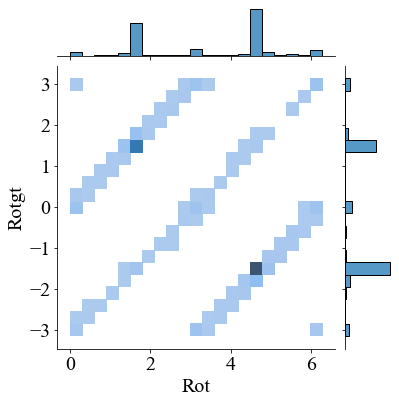

In [ ]:
sns.jointplot(data=df, x="Rot", y="Rotgt", kind="hist")

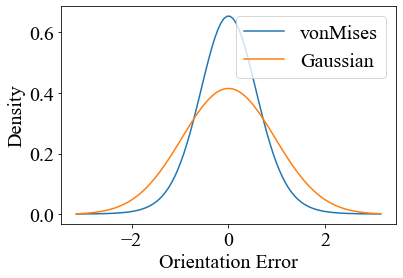

In [26]:
roterrors = (df.Rot - df.Rotgt) % (2*np.pi)
roterrors = np.where(roterrors > np.pi, roterrors - 2*np.pi, roterrors)
# roterrors = roterrors[(-2 < roterrors) & (roterrors < 2)]

kappa, loc, scale = stats.vonmises.fit(roterrors, floc=0, fscale=1)
assert scale == 1
assert loc == 0
x = np.linspace(-np.pi, np.pi, 100)
y = stats.vonmises.pdf(x, kappa)
plt.plot(x, y, label="vonMises")

loc, scale = stats.norm.fit(roterrors, floc=0)
y = stats.norm.pdf(x, scale=scale)
plt.plot(x, y, label="Gaussian")

# plt.hist(roterrors, bins=360, density=True)
plt.xlabel("Orientation Error")
plt.ylabel("Density")
plt.legend()
plt.show()


In [ ]:
# names = ["X", "Y", "Z", "L", "H", "W", "Rot"]
# table = {"name": [], "RECE": [], "method": []}

# for n in names:
#     table["name"].append(n)
#     y_true = df[n].to_numpy()
#     y_pred = df[n + "gt"].to_numpy()
#     calibed = calibreg(n, show_img=False)
#     prob_true, prob_pred = reg_calibration_curve(y_true, y_pred, calibed, n_bins=20)